# Scientific Computation Project


# Brain Tumor Classification (MRI)


## Import Libraries


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

## Tumor types and classes


1. **glioma_tumor:** Refers to tumors that arise from glial cells in the brain, including types like glioblastoma multiforme (GBM) and astrocytomas.

2. **no_tumor:** Indicates the absence of any detectable tumor.

3. **meningioma_tumor:** Refers to tumors that form in the meninges, the layers of tissue covering the brain and spinal cord. Meningiomas are generally slow-growing and can be benign.

4. **pituitary_tumor:** Indicates tumors that develop in the pituitary gland, a small gland at the base of the brain responsible for hormone regulation.


In [20]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

## Data Preperation


### Load MRI Images


In [21]:
class LoadData:

    DATASET_ROOT_DIRECTORY = '../tumor-dataset/'
    IMAGE_SIZE = 150

    def exec(self) -> (np.array, np.array):
        X_train, y_train = [], []
        for mode in ['Training', 'Testing']:
            for i in labels:
                folderPath = os.path.join(self.DATASET_ROOT_DIRECTORY, mode, i)
                for j in tqdm(os.listdir(folderPath)):
                    img = cv2.imread(os.path.join(folderPath, j))
                    img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE))
                    X_train.append(img)
                    y_train.append(i)
        return np.array(X_train), np.array(y_train)

In [22]:
loadData = LoadData()
X_train, y_train = loadData.exec()

100%|██████████| 74/74 [00:00<00:00, 545.81it/s]


### Some Samples


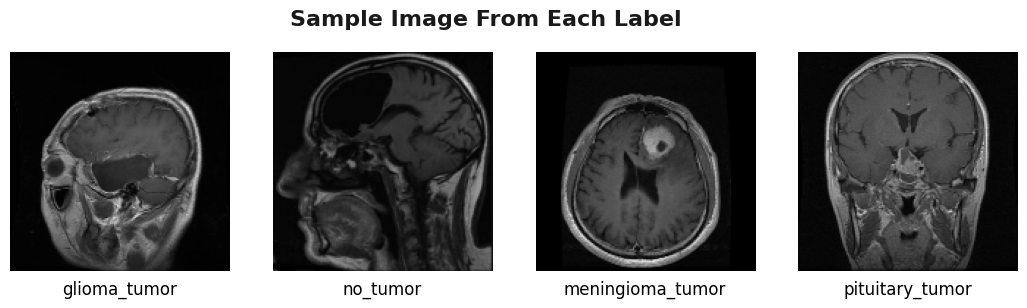

In [8]:
k = 0
fig, ax = plt.subplots(1, 4, figsize=(13, 13))
fig.text(s='Sample Image From Each Label', size=16, fontweight='bold',
         y=0.60, x=0.34, alpha=0.9)

for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j], y=-0.14)
            ax[k].axis('off')
            k += 1
            break
        j += 1

Shuffle training data and labels using shuffle function with a specified random seed


In [9]:
X_train, y_train = shuffle(X_train, y_train, random_state=101)

split training data into test and training data, The test set size is set to $10\%$


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.1, random_state=101)

### One Hot Encoding


Convert categorical labels to numerical representation


In [11]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## Transfer Learning


Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to shortcut this process is to reuse the model weights from pre-trained models developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top-performing models can be downloaded and used directly or integrated into a new model for your own computer vision problems.

In this project, I'll be using the EfficientNetB0 model, which will utilize the weights from the ImageNet dataset.


In [13]:
effnet = EfficientNetB0(weights='imagenet', include_top=False,
                        input_shape=(loadData.IMAGE_SIZE, loadData.IMAGE_SIZE, 3))

### Designe Last Layer


In [14]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs=model)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam', metrics=['accuracy'])

In [17]:
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint(
    "effnet.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001,
                              mode='auto', verbose=1)

## Training The Model


In [16]:
history = model.fit(X_train, y_train, validation_split=0.1,
                    epochs=12, verbose=1, batch_size=32)

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.8301
Epoch 1: val_accuracy improved from -inf to 0.81633, saving model to effnet.h5


/Users/mohazamani/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 79s 913ms/step - loss: 0.4693 - accuracy: 0.8301 - val_loss: 0.5921 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9345
Epoch 2: val_accuracy improved from 0.81633 to 0.89116, saving model to effnet.h5
83/83 [==============================] - 70s 837ms/step - loss: 0.2004 - accuracy: 0.9345 - val_loss: 0.3249 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9584
Epoch 3: val_accuracy improved from 0.89116 to 0.90476, saving model to effnet.h5
83/83 [==============================] - 67s 809ms/step - loss: 0.1236 - accuracy: 0.9584 - val_loss: 0.3439 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9728
Epoch 4: val_accuracy improved from 0.90476 to 0.93878, saving model to effnet.h5
83/83 [==============================

### Training And Validation Sets Accuracy


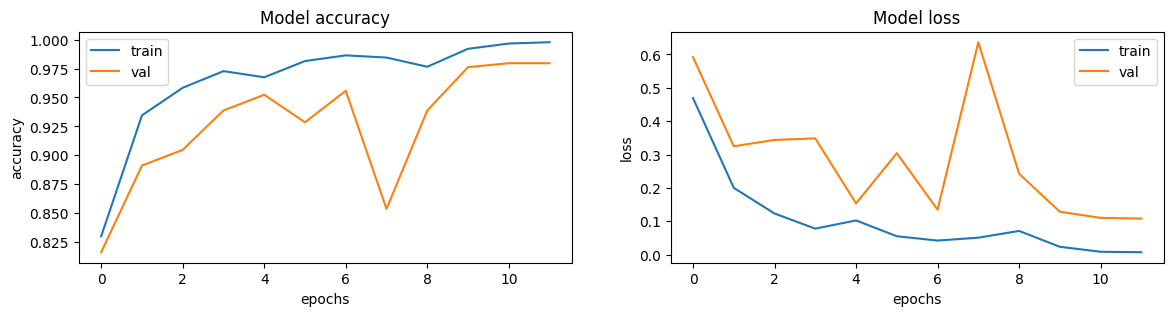

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Perediction And Evaluation


In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

11/11 [==============================] - 2s 158ms/step


In [20]:
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        93
           1       0.98      1.00      0.99        51
           2       0.95      0.96      0.95        96
           3       0.99      1.00      0.99        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



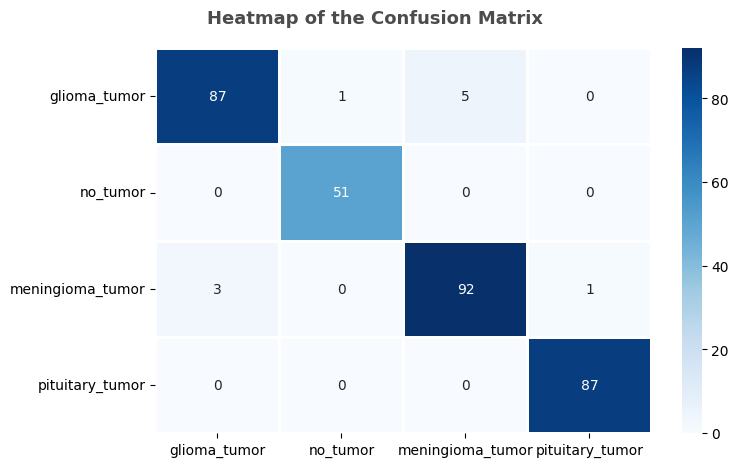

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap="Blues", alpha=1, linewidths=1)
fig.text(s='Heatmap of the Confusion Matrix', size=13, fontweight='bold',
         y=0.93, x=0.19, alpha=0.7)

plt.show()

In [55]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print("test accuracy : ", test_acc * 100, "%")

11/11 - 2s - loss: 0.0934 - accuracy: 0.9694 - 2s/epoch - 182ms/step
test accuracy :  96.94189429283142 %
